# Dynamic Time Warping
DTW follows a x-step process:
1. Select a window size with which to calculate DTW-distance between slices. In this program,
we select the number of observations _n_ into which the data should be divided, with a
window size of ```step = len(df) / n```. In order to prevent high degrees of dissimilarity
between the remaining data points not included in the window size, the first ```len(df) % step```
points are removed from the dataframe.
2. Calculate the DTW-distance between every pair of slices.
3. Utilize a clustering algorithm (k-means) to

In [1]:
#Import Packages

import pandas as pd
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn import preprocessing
from sklearn_extra.cluster import KMedoids
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
#Load Files

all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

dfs=[]
for path in all_files:
    df = pd.read_csv(path,sep=';', index_col='datetime', parse_dates=True)
    dfs.append(df)
print('Features:')
for col in dfs[1].columns:
    print('\t',col)

col_names = list(dfs[1].columns[0:8])

Features:
	 Accelerometer1RMS
	 Accelerometer2RMS
	 Current
	 Pressure
	 Temperature
	 Thermocouple
	 Voltage
	 Volume Flow RateRMS
	 anomaly
	 changepoint


In [3]:
# Split into n observations

def df_split(df, n):
    step = math.floor(len(df)/n)
    remainder = len(df) % step
    splits = [remainder]
    while max(splits) < len(df):
        splits.append(max(splits) + step)
    splits[-1] = -1
    locs = df.iloc[splits].index
    arrays = []
    for i in range(len(splits) - 1):
        st = locs[i]
        end = locs[i+1]
        arrays.append(df[st:end])
    return arrays, locs


def timewarp(arrays):
    d = np.zeros((len(arrays), len(arrays)))
    for pair in itertools.product(range(len(arrays)), repeat=2):
        template = arrays[pair[0]]
        query = arrays[pair[1]]
        alignment = dtw(query, template, keep_internals=True)
        d[pair[0], pair[1]] = alignment.distance
    return d


..\data\valve1\12.csv


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,0.027476,0.040633,0.972674,0.058738,68.610787,24.654054,230.242763,30.981714,0.350000,0.003509
std,0.000367,0.001390,0.274368,0.254091,1.274362,0.021407,10.653245,1.665692,0.477179,0.059157
min,0.026445,0.037547,0.372564,-0.929070,65.420200,24.580700,204.222000,28.000000,0.000000,0.000000
25%,0.027219,0.039697,0.737613,0.054711,67.830225,24.644000,224.507750,29.000000,0.000000,0.000000
50%,0.027508,0.040424,0.978509,0.054711,68.722500,24.653600,230.836000,32.000000,0.000000,0.000000
75%,0.027737,0.041349,1.206535,0.054711,69.774275,24.664600,236.145250,32.000000,1.000000,0.000000
max,0.028437,0.047115,1.560930,0.710565,70.485700,24.726400,254.613000,33.000000,1.000000,1.000000


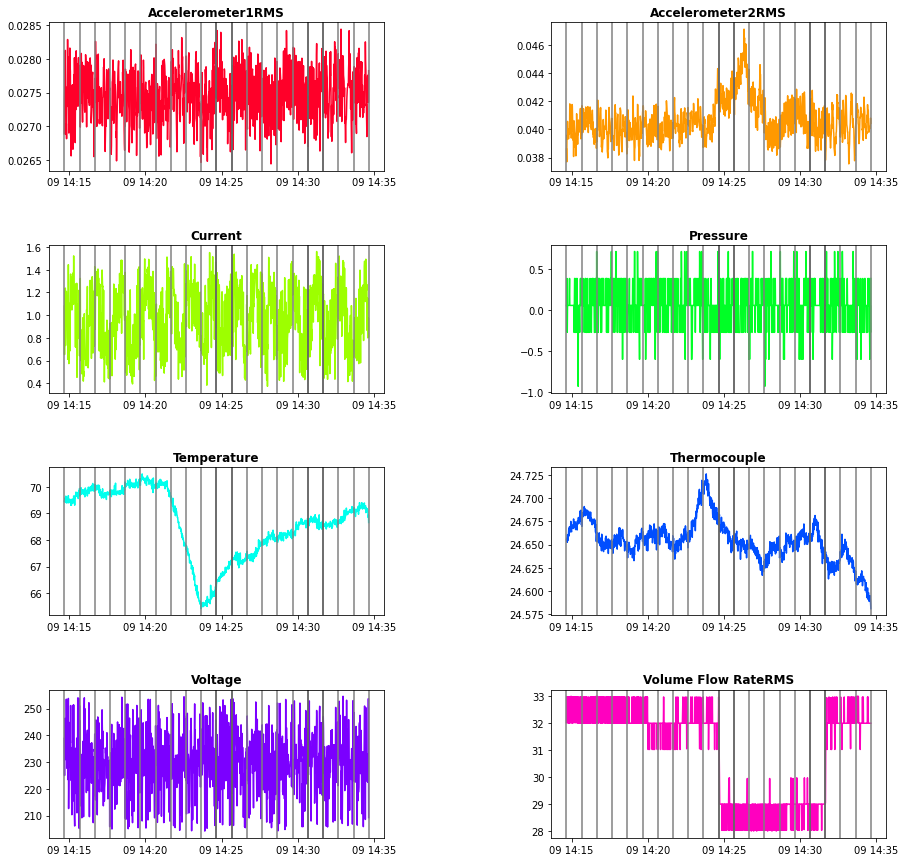

In [4]:
# Plot Data
experiments = [19]
for i in experiments:
    print(all_files[i].replace("/","\\"))
    display(dfs[i].describe())
    df = dfs[i]
    fig, axes = plt.subplots(nrows=4, ncols=2)
    color = iter(cm.gist_rainbow(np.linspace(0, 1, len(df.columns)-2)))
    points = df.index[df['changepoint'] == 1].tolist()
    arrays, locs = df_split(df, 20)

    for col, ax in zip(df.columns[0:8], axes.flatten()):
        c = next(color)
        ax.set_title(col, fontweight="bold")
        ax.plot(df[col], c=c)
        for p in points:
            ax.axvline(p, color="black")
        for loc in locs:
            ax.axvline(loc, color="gray")
        plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.set_facecolor('white')
    fig.set_size_inches(15, 15)

In [5]:
#Standardize Data
dfs_stand = []
for df in dfs:
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[col_names])
    dfs_stand.append(pd.DataFrame(data=scaler.transform(df[col_names]), index=df.index, columns=col_names))

In [6]:
# DTW Attempt 1
Ds = []
labels = []
highlights = []
for df in dfs_stand:
    arrays, locs = df_split(df, 20)
    d = timewarp(arrays)
    kmedoids = KMedoids(n_clusters=2, metric='precomputed', method='pam', init='heuristic').fit(np.array(d))
    label = kmedoids.labels_
    if sum(label) > 0.5 * len(label):
        label = 1 - np.array(label)
    highlight = [(arrays[i].index[0], arrays[i].index[-1]) for i, x in enumerate(label) if x == 1]
    Ds.append(d)
    labels.append(label)
    highlights.append(highlight)

..\data\other\12.csv


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000
mean,0.081098,0.132212,1.573211,0.011449,86.980258,22.112552,230.035659,76.047435,0.350044,0.003518
std,0.000639,0.002566,0.385167,0.256350,0.857701,0.016770,11.052438,1.041825,0.477193,0.059235
min,0.079158,0.125210,0.598223,-0.601143,85.280200,22.078000,203.887000,74.000000,0.000000,0.000000
25%,0.080629,0.130171,1.296880,-0.273216,86.364100,22.099900,223.636000,75.000000,0.000000,0.000000
50%,0.081074,0.132053,1.654900,0.054711,86.824800,22.110100,230.496000,76.020100,0.000000,0.000000
75%,0.081548,0.134189,1.869030,0.054711,87.596400,22.126100,236.537000,77.000000,1.000000,0.000000
max,0.083113,0.138839,2.328460,0.710565,88.993500,22.155600,254.611000,78.000000,1.000000,1.000000


..\data\other\20.csv


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,0.238646,0.290395,2.418080,0.098214,85.137640,30.768303,227.525908,128.262455,0.378673,0.003359
std,0.004933,0.008191,0.495027,0.264646,0.357162,0.527378,10.930676,0.779631,0.485260,0.057880
min,0.226751,0.273341,0.933653,-1.257000,84.401000,29.960000,201.265000,125.312000,0.000000,0.000000
25%,0.235512,0.283859,2.133500,0.054711,84.850450,30.224800,221.739500,128.000000,0.000000,0.000000
50%,0.238227,0.288316,2.553740,0.054711,85.131600,30.744700,227.806000,128.312000,0.000000,0.000000
75%,0.241025,0.298242,2.756350,0.382638,85.360800,31.277700,234.011500,128.690000,1.000000,0.000000
max,0.257534,0.309150,3.296250,1.038490,86.006300,31.628800,251.138000,130.690000,1.000000,1.000000


..\data\valve1\10.csv


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1146.000000,1146.000000,1146.000000,1146.000000,1146.000000,1146.000000,1146.000000,1146.000000,1146.000000,1146.000000
mean,0.027755,0.041471,0.970104,0.063295,68.517408,24.751428,230.386684,31.523800,0.349913,0.003490
std,0.000481,0.001685,0.277052,0.264199,0.892976,0.016573,11.421049,1.157294,0.477150,0.059002
min,0.026094,0.038207,0.399169,-0.601143,66.236000,24.718100,203.518000,29.000000,0.000000,0.000000
25%,0.027391,0.040347,0.731540,0.054711,67.866225,24.740800,223.675250,30.000000,0.000000,0.000000
50%,0.027762,0.041251,0.985958,0.054711,68.570450,24.749800,230.646000,32.000000,0.000000,0.000000
75%,0.028126,0.042215,1.193158,0.054711,69.239675,24.758400,237.005000,32.020100,1.000000,0.000000
max,0.028911,0.047824,1.569300,1.038490,70.156000,24.833300,254.767000,32.980800,1.000000,1.000000


..\data\valve1\12.csv


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000,1140.000000
mean,0.027476,0.040633,0.972674,0.058738,68.610787,24.654054,230.242763,30.981714,0.350000,0.003509
std,0.000367,0.001390,0.274368,0.254091,1.274362,0.021407,10.653245,1.665692,0.477179,0.059157
min,0.026445,0.037547,0.372564,-0.929070,65.420200,24.580700,204.222000,28.000000,0.000000,0.000000
25%,0.027219,0.039697,0.737613,0.054711,67.830225,24.644000,224.507750,29.000000,0.000000,0.000000
50%,0.027508,0.040424,0.978509,0.054711,68.722500,24.653600,230.836000,32.000000,0.000000,0.000000
75%,0.027737,0.041349,1.206535,0.054711,69.774275,24.664600,236.145250,32.000000,1.000000,0.000000
max,0.028437,0.047115,1.560930,0.710565,70.485700,24.726400,254.613000,33.000000,1.000000,1.000000


..\data\valve1\6.csv


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1154.000000,1154.000000,1154.000000,1154.000000,1154.000000,1154.000000,1154.000000,1154.000000,1154.000000,1154.000000
mean,0.027469,0.040493,1.171056,0.064941,69.874411,25.013223,230.564553,31.997424,0.350953,0.003466
std,0.000416,0.001115,6.778300,0.257852,0.825751,0.051064,12.647964,0.702813,0.477475,0.058798
min,0.025911,0.037424,0.360870,-0.929070,68.188900,24.906800,1.236710,30.011700,0.000000,0.000000
25%,0.027160,0.039708,0.729828,0.054711,69.347950,24.965725,224.917500,31.988200,0.000000,0.000000
50%,0.027481,0.040439,0.991071,0.054711,69.676750,25.010000,230.847000,32.000000,0.000000,0.000000
75%,0.027771,0.041142,1.210003,0.054711,70.062125,25.062300,237.157750,32.012600,1.000000,0.000000
max,0.028540,0.044457,231.046000,1.366420,71.821500,25.136300,254.621000,33.000000,1.000000,1.000000


..\data\valve2\2.csv


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000
mean,0.027610,0.040199,0.984195,0.071848,68.038492,24.200085,230.906186,31.585149,0.349867,0.003543
std,0.000369,0.001238,0.268601,0.270217,0.834562,0.024996,10.475457,0.771671,0.477139,0.059444
min,0.026528,0.036425,0.383591,-0.601143,65.705000,24.147100,204.164000,30.000000,0.000000,0.000000
25%,0.027365,0.039321,0.767588,0.054711,67.408400,24.178400,225.513000,31.000000,0.000000,0.000000
50%,0.027606,0.040245,1.001410,0.054711,68.264000,24.199300,231.132000,32.000000,0.000000,0.000000
75%,0.027847,0.041092,1.212050,0.382638,68.721700,24.220800,236.728000,32.000000,1.000000,0.000000
max,0.031339,0.043516,1.525770,1.038490,69.333900,24.255400,254.734000,32.960300,1.000000,1.000000


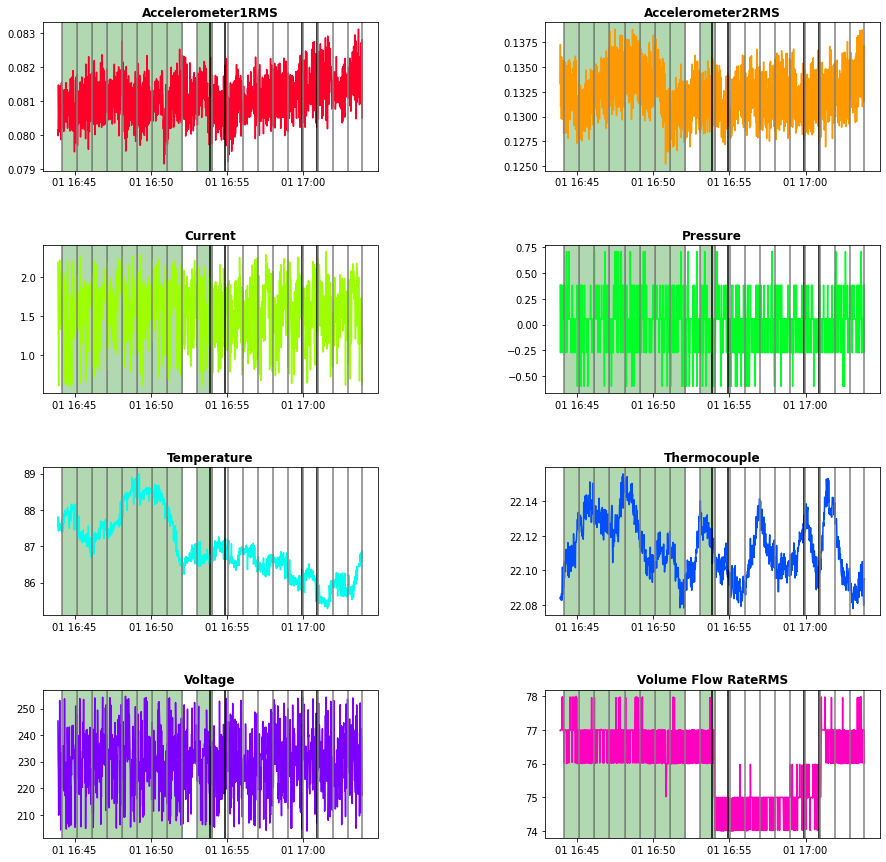

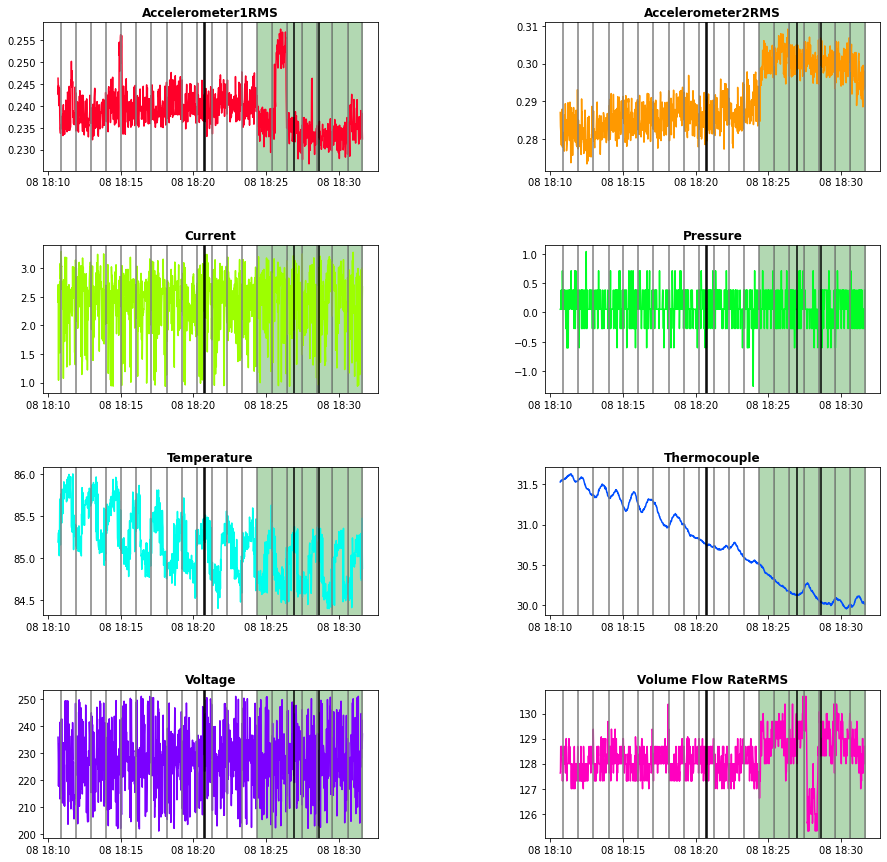

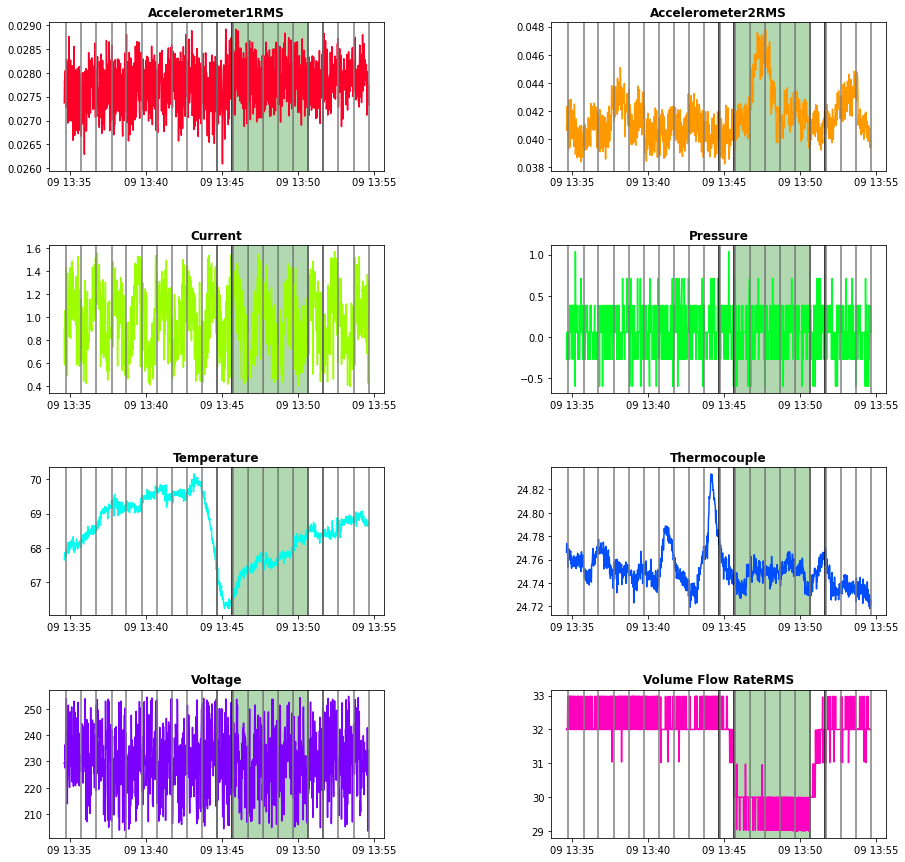

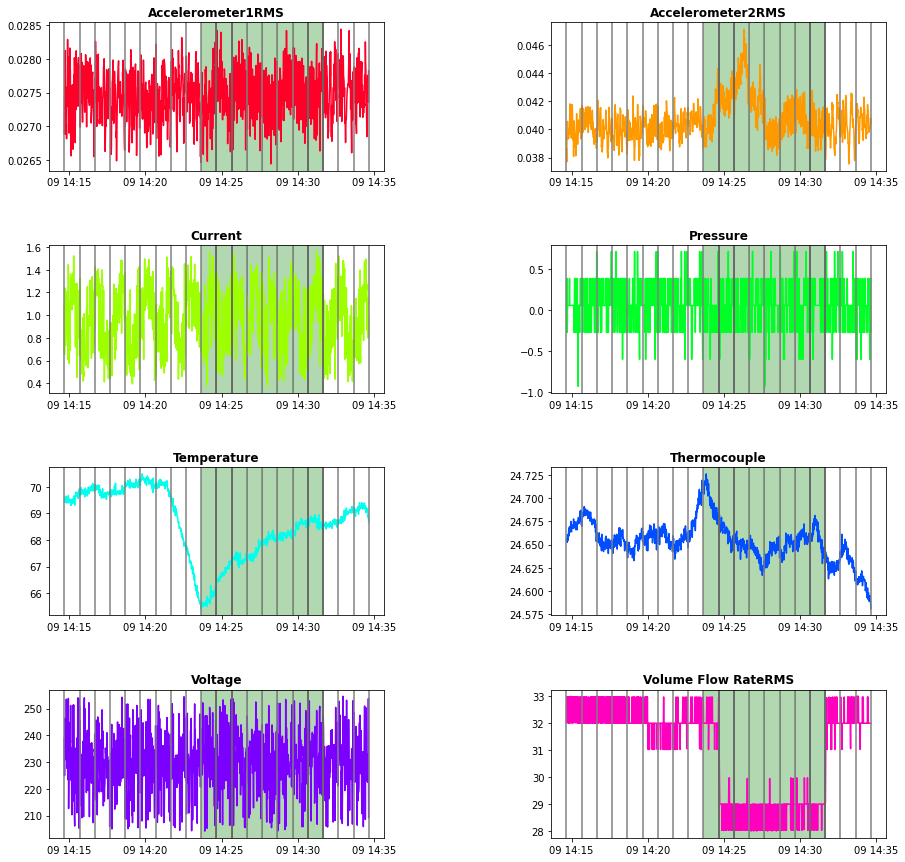

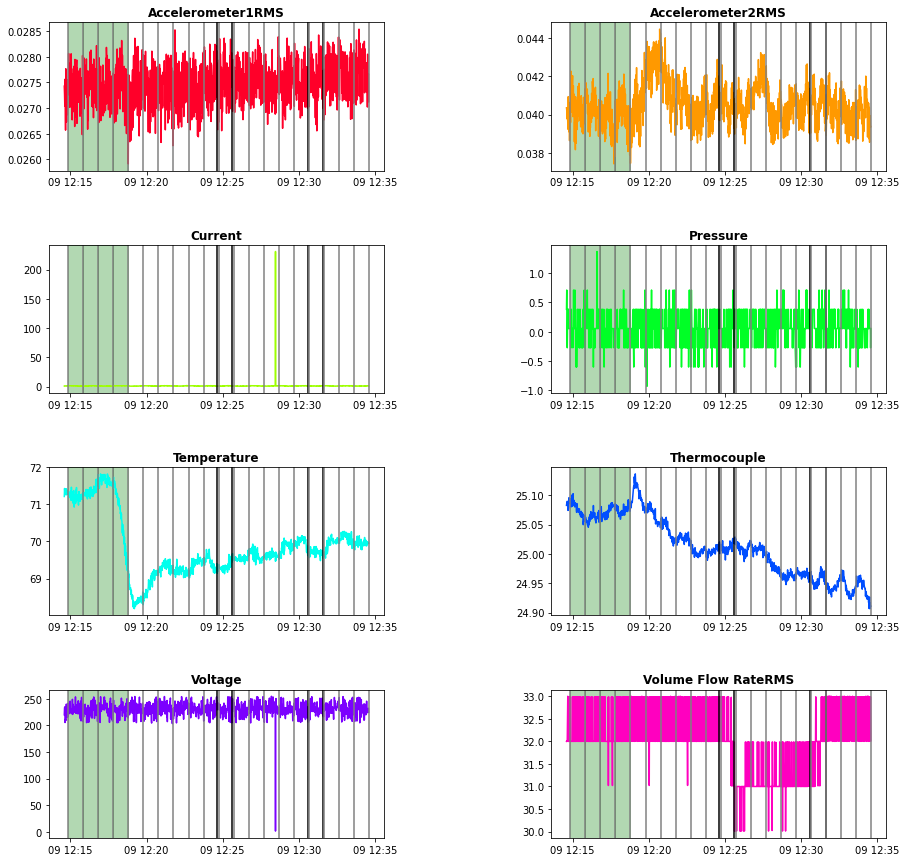

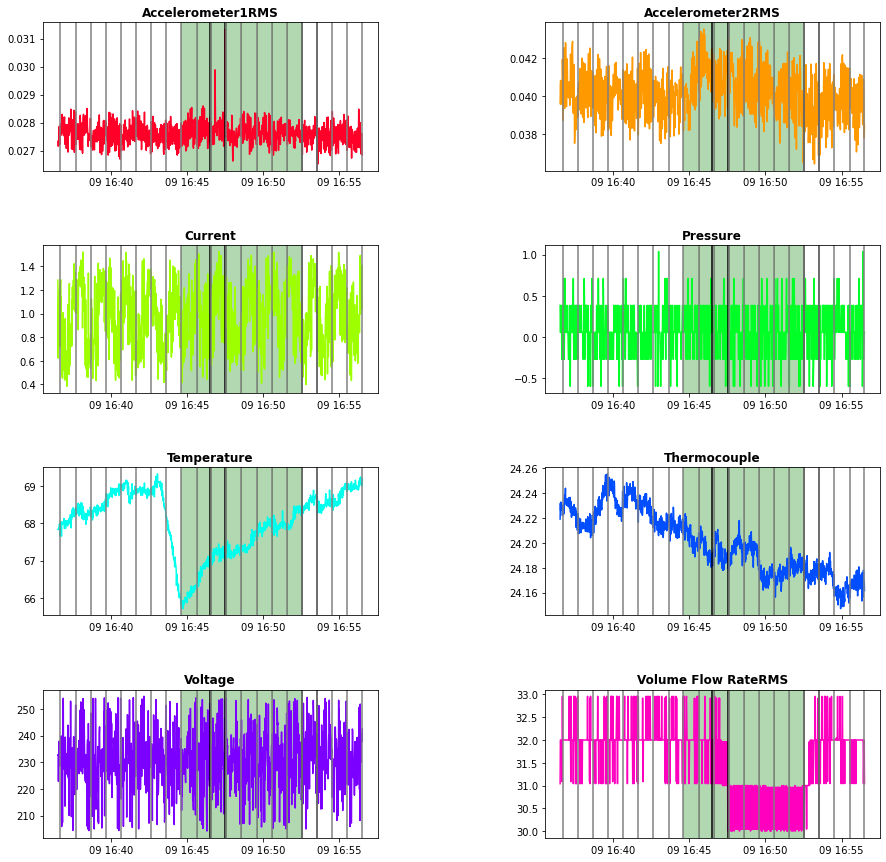

In [9]:
experiments = [2, 10, 17, 19, 27, 33]
for i in experiments:
    print(all_files[i].replace("/","\\"))
    display(dfs[i].describe())
    df = dfs[i]
    fig, axes = plt.subplots(nrows=4, ncols=2)
    color = iter(cm.gist_rainbow(np.linspace(0, 1, len(df.columns)-2)))
    points = df.index[df['changepoint'] == 1].tolist()
    preds = highlights[i]
    arrays, locs = df_split(df, 20)

    for col, ax in zip(df.columns[0:8], axes.flatten()):
        c = next(color)
        ax.set_title(col, fontweight="bold")
        ax.plot(df[col], c=c)
        for p in points:
            ax.axvline(p, color="black")
        for loc in locs:
            ax.axvline(loc, color="gray")
        for pred in preds:
            ax.axvspan(pred[0], pred[1], alpha=0.3, color='green')
        plt.subplots_adjust(wspace=.5, hspace=.5)
    fig.set_facecolor('white')
    fig.set_size_inches(15, 15)
